# Comparing algorithms on the Internet dataset
The data is taken from [this source](https://kdd.ics.uci.edu/databases/internet_usage/internet_usage.html).

For details on running the comparison, see [this article](https://github.com/catboost/benchmarks/blob/master/comparison_description.pdf).

In [1]:
import sys

sys.path.append("..")

sys.path

['',
 '/home/yannick/bin/anaconda3/envs/py27/lib/python27.zip',
 '/home/yannick/bin/anaconda3/envs/py27/lib/python2.7',
 '/home/yannick/bin/anaconda3/envs/py27/lib/python2.7/plat-linux2',
 '/home/yannick/bin/anaconda3/envs/py27/lib/python2.7/lib-tk',
 '/home/yannick/bin/anaconda3/envs/py27/lib/python2.7/lib-old',
 '/home/yannick/bin/anaconda3/envs/py27/lib/python2.7/lib-dynload',
 '/home/yannick/bin/anaconda3/envs/py27/lib/python2.7/site-packages',
 '/home/yannick/bin/anaconda3/envs/py27/lib/python2.7/site-packages/Keras-1.0.5-py2.7.egg',
 '/home/yannick/bin/anaconda3/envs/py27/lib/python2.7/site-packages/mxnet-0.7.0-py2.7.egg',
 '/home/yannick/bin/anaconda3/envs/py27/lib/python2.7/site-packages/h2ohyperopt-0.3-py2.7.egg',
 '/home/yannick/bin/anaconda3/envs/py27/lib/python2.7/site-packages/pymongo-2.2-py2.7-linux-x86_64.egg',
 '/home/yannick/bin/anaconda3/envs/py27/lib/python2.7/site-packages/pydot_ng-1.0.1.dev0-py2.7.egg',
 '/home/yannick/bin/anaconda3/envs/py27/lib/python2.7/site-pac

In [2]:
%load_ext autoreload

%autoreload 1

In [3]:
from experiment import Experiment
from xgboost_experiment import XGBExperiment
from lightgbm_experiment import LGBExperiment
from catboost_experiment import CABExperiment

/home/yannick/bin/anaconda3/envs/py27/lib/python2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


Load the dataset and set parameters for the experiment.

In [4]:
learning_task = 'classification'
dataset_path = '../prepare_internet/'
n_estimators = 5000
max_hyperopt_evals = 50

experiment = Experiment(learning_task, train_path=dataset_path + 'train',
                        test_path=dataset_path + 'test', cd_path = dataset_path + 'train.cd')
X_train, y_train, X_test, y_test, cat_cols = experiment.read_data()

Write a function that does the following:

**Preprocess the dataset:**
calculate counter values on the training set, transform cat features (for the `XGBoost` and `LightGBM` algorithms), and convert the data to the format of the algorithm. Do the same thing with all pairs after splitting them into cross validation folds.

**Select the optimal number of trees for the algorithm with the default parameters:** for each fold and each number of trees, get the result of the algorithm trained on the other four folds, average the results for each number of trees, and choose the best one. 

**Assess the quality of the algorithm with the default parameters on a test dataset:** train the algorithm with the number of trees obtained in the previous step, and calculate the metric value on the test dataset.

**Tune parameters for the algorithm using `Hyperopt`:** on each `Hyperopt` iteration of the algorithm, the best value of trees is selected and the metric for cross validation is calculated.

**Show results on the test dataset for the algorithm with the tuned parameters:** train the algorithm with the optimal parameters and the number of trees obtained in the previous step, and calculate the metric value on the test dataset.

In [5]:
import numpy as np

def run_experiment(Experiment, title):
    experiment = Experiment(learning_task, max_hyperopt_evals=max_hyperopt_evals,
                            n_estimators=n_estimators)
    cv_pairs, (dtrain, dtest) = experiment.split_and_preprocess(X_train.copy(), y_train, 
                                                                X_test.copy(), y_test, 
                                                                cat_cols, n_splits=5)
 
    default_cv_result = experiment.run_cv(cv_pairs)
    experiment.print_result(default_cv_result, 'Default {} result on cv'.format(title))

    print('\n~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~\n')

    default_test_losses = []
    for seed in range(5):
        test_result = experiment.run_test(dtrain, dtest, X_test, params=default_cv_result['params'],
                                          n_estimators=default_cv_result['best_n_estimators'], seed=seed)
        default_test_losses.append(test_result['loss'])
        print 'For seed=%d Test\'s %s : %.5f' % (seed, experiment.metric, default_test_losses[-1])
    print '\nTest\'s %s mean: %.5f, Test\'s %s std: %.5f' % (experiment.metric, np.mean(default_test_losses),
                                                             experiment.metric, np.std(default_test_losses))

    print('\n~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~\n')
    print('Hyperopt iterations:\n\n')

    tuned_cv_result = experiment.optimize_params(cv_pairs)

    print('\n~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~\n')

    experiment.print_result(tuned_cv_result, 'Tuned {} result on cv'.format(title))

    print('\n~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~\n')

    tuned_test_losses = []
    for seed in range(5):
        test_result = experiment.run_test(dtrain, dtest, X_test, params=tuned_cv_result['params'],
                                          n_estimators=tuned_cv_result['best_n_estimators'], seed=seed)
        tuned_test_losses.append(test_result['loss'])
        print 'For seed=%d Test\'s %s : %.5f' % (seed, experiment.metric, tuned_test_losses[-1])
    print '\nTest\'s %s mean: %.5f, Test\'s %s std: %.5f' % (experiment.metric, np.mean(tuned_test_losses),
                                                             experiment.metric, np.std(tuned_test_losses))

    return np.mean(default_test_losses), np.mean(tuned_test_losses)

## `XGBoost`

In [6]:
xgb_default_test_result, xgb_tuned_test_result = run_experiment(XGBExperiment, "XGBoost")

Default XGBoost result on cv:

logloss = 0.2403498
best_n_estimators = 23
params = {'colsample_bytree': 1.0, 'silent': 1, 'eval_metric': 'logloss', 'colsample_bylevel': 1.0, 'min_child_weight': 1, 'subsample': 1.0, 'eta': 0.3, 'objective': 'binary:logistic', 'alpha': 0, 'seed': 0, 'max_depth': 6, 'gamma': 0, 'lambda': 1}

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

For seed=0 Test's logloss : 0.23468
For seed=1 Test's logloss : 0.23468
For seed=2 Test's logloss : 0.23468
For seed=3 Test's logloss : 0.23468
For seed=4 Test's logloss : 0.23468

Test's logloss mean: 0.23468, Test's logloss std: 0.00000

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Hyperopt iterations:


[1/50]	eval_time=30.16 sec	current_logloss=0.267741	min_logloss=0.267741
[2/50]	eval_time=435.47 sec	current_logloss=0.234354	min_logloss=0.234354
[3/50]	eval_time=73.52 sec	current_logloss=0.243668	min_logloss=0.234354
[4/50]	eval_time=70.74 sec	current_logloss=0.231636	min_logloss=0.231636
[5/50]	eval_

## `LightGBM`

In [7]:
lgb_default_test_result, lgb_tuned_test_result = run_experiment(LGBExperiment, "LightGBM")

Default LightGBM result on cv:

logloss = 0.240168190538
best_n_estimators = 54
params = {'num_leaves': 127, 'verbose': -1, 'bagging_seed': 3, 'learning_rate': 0.1, 'data_random_seed': 1, 'min_data_in_leaf': 100, 'bagging_fraction': 1.0, 'metric': 'binary_logloss', 'feature_fraction_seed': 2, 'lambda_l1': 0, 'bagging_freq': 1, 'lambda_l2': 0, 'max_bin': 255, 'objective': 'binary', 'drop_seed': 4, 'min_sum_hessian_in_leaf': 10, 'feature_fraction': 1.0}

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

For seed=0 Test's logloss : 0.23399
For seed=1 Test's logloss : 0.23399
For seed=2 Test's logloss : 0.23399
For seed=3 Test's logloss : 0.23399
For seed=4 Test's logloss : 0.23399

Test's logloss mean: 0.23399, Test's logloss std: 0.00000

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Hyperopt iterations:


[1/50]	eval_time=14.55 sec	current_logloss=0.255516	min_logloss=0.255516
[2/50]	eval_time=12.38 sec	current_logloss=0.236473	min_logloss=0.236473
[3/50]	eval_time=17.79 sec

## `CatBoost`

In [8]:
import catboost

catboost.__version__

'0.3.1'

In [9]:
cab_default_test_result, cab_tuned_test_result = run_experiment(CABExperiment, "CatBoost")

Default CatBoost result on cv:

logloss = 0.223204754
best_n_estimators = 995
params = {'rsm': 1.0, 'random_seed': 0, 'verbose': False, 'thread_count': 16, 'learning_rate': 0.03, 'ctr_border_count': 16, 'ctr_description': ['Borders', 'Counter'], 'iterations': 5000, 'gradient_iterations': 10, 'depth': 6, 'loss_function': 'Logloss', 'fold_len_multiplier': 2, 'kwargs': {}, 'leaf_estimation_method': 'Newton', 'l2_leaf_reg': 3, 'border_count': 128, 'used_ram_limit': 100000000000}

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

For seed=0 Test's logloss : 0.21633
For seed=1 Test's logloss : 0.21714
For seed=2 Test's logloss : 0.21873
For seed=3 Test's logloss : 0.22012
For seed=4 Test's logloss : 0.21845

Test's logloss mean: 0.21816, Test's logloss std: 0.00131

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Hyperopt iterations:


[1/50]	eval_time=1214.19 sec	current_logloss=0.220263	min_logloss=0.220263
[2/50]	eval_time=685.28 sec	current_logloss=0.218528	min_logloss=0.218528

## Comparing results

The final table with metric values on the test dataset.

Populating the interactive namespace from numpy and matplotlib


,default,tuned
xgboost,0.234678 (+12.66%),0.224060 (+7.57%)
lightgbm,0.233989 (+12.33%),0.227115 (+9.03%)
catboost,0.218155 (+4.73%),0.208298 (+0.00%)


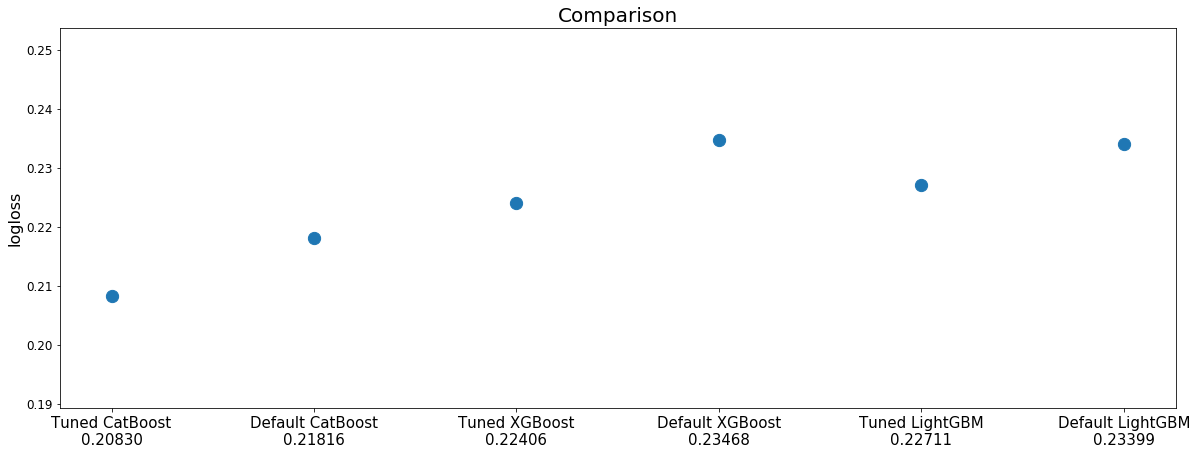

In [11]:
import pandas as pd
import numpy as np
from IPython.display import HTML, display
%pylab inline --no-import-all

test_results = np.array([
    (xgb_default_test_result, xgb_tuned_test_result),
    (lgb_default_test_result, lgb_tuned_test_result),
    (cab_default_test_result, cab_tuned_test_result)
])

diff = 100 * test_results / test_results[2,1] - 100

res = [['{:.6f} ({:+.2f}%)'.format(test_results[i, j], diff[i, j]) for j in range(2)] for i in range(3)]

display(HTML(pd.DataFrame(res, columns=['default', 'tuned'], index=['xgboost', 'lightgbm', 'catboost']).to_html()))

results = [
    ('Tuned CatBoost',   cab_tuned_test_result),
    ('Default CatBoost', cab_default_test_result),
    ('Tuned XGBoost',    xgb_tuned_test_result),
    ('Default XGBoost',  xgb_default_test_result),
    ('Tuned LightGBM',   lgb_tuned_test_result),
    ('Default LightGBM', lgb_default_test_result),
]
names = ['%s\n%.5f' % (name, loss) for name, loss in results]

plt.figure(figsize=(20, 7))
plt.scatter(range(6), zip(*results)[1], s=150)
plt.xticks(range(6), names, fontsize=15)
plt.yticks(fontsize=12)
plt.title('Comparison', fontsize=20)
plt.ylabel(experiment.metric, fontsize=16);